In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.8 MB/s eta 0:00:00


In [3]:
import argparse
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import layers, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.models import load_model, Model
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner.tuners import RandomSearch
class_map = {'eagle': 0, 'panda': 1, 'polar-bear': 2}

# Učitavanje slika i oznaka
train_imgs = np.load('drive/MyDrive/cropped/train_imgs.npy')
train_labels = np.load('drive/MyDrive/cropped/train_labels.npy')
test_imgs = np.load('drive/MyDrive/cropped/test_imgs.npy')
test_labels = np.load('drive/MyDrive/cropped/test_labels.npy')
val_imgs = np.load('drive/MyDrive/cropped/val_imgs.npy')
val_labels = np.load('drive/MyDrive/cropped/val_labels.npy')

print(f"train_imgs shape: {train_imgs.shape}")
print(f"test_imgs shape: {test_imgs.shape}")
print(f"val_imgs shape: {val_imgs.shape}")


# Augmentacija slika
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,

)

# Kreiranje skupa podataka
train_set = train_datagen.flow(
    train_imgs,
    train_labels,
    batch_size=32,
    shuffle=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
)

val_set = val_datagen.flow(
    val_imgs,
    val_labels,
    batch_size=32,
    shuffle=False
)

<ipython-input-3-76ee34ad0e26>:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


train_imgs shape: (2459, 224, 224, 3)
test_imgs shape: (769, 224, 224, 3)
val_imgs shape: (615, 224, 224, 3)


In [4]:
import argparse
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import layers, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.models import load_model, Model
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner.tuners import RandomSearch

#Pomocne metode
def report_model(md, model_name, images, labels, classes):
    print("**********REPORT FOR ", model_name.upper(), " MODEL********** /n")
    predictions = md.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    report = classification_report(labels, predicted_labels, target_names=list(classes.keys()),
                                   labels=list(classes.values()))
    print(report)
    print("******************************************")

def build_model(hp):
    base_model = keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
    )

    num_frozen_layers = hp.Int('num_frozen_layers', min_value=50, max_value=310, step=10)


    for layer in base_model.layers[:num_frozen_layers]:
        layer.trainable = False
    for layer in base_model.layers[num_frozen_layers:]:
        layer.trainable = True

    x = base_model.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(hp.Int('units', min_value=700, max_value=2048, step=200), activation='relu')(x)
    if hp.Boolean("dropout"):
        x = keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.07, max_value=0.3, step=0.1))(x)

    predictions = keras.layers.Dense(3, activation='softmax')(x)

    model = keras.models.Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model






In [ ]:
#Optimizacija hiperparametara
tuner = kt.RandomSearch(
      build_model,
      objective='val_loss',
      max_trials=5)

tuner.search(train_set, epochs=5, validation_data=val_set)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Ispis hiperparametara
print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Trial 5 Complete [00h 05m 28s]
val_loss: 0.23547224700450897

Best val_loss So Far: 0.03883394971489906
Total elapsed time: 00h 23m 58s
Best Hyperparameters:
num_frozen_layers: 260
units: 1900
dropout: False
lr: 0.0008053532244671809
dropout_rate: 0.27


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 111, 111, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 111, 111, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 109, 109, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 109, 109, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 109, 109, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 109, 109, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 54, 54, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 54, 54, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 111, 111, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 111, 111, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 109, 109, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 109, 109, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 109, 109, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 109, 109, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 54, 54, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 54, 54, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 25,701,587 (98.04 MB)

 Trainable params: 11,514,483 (43.92 MB)

 Non-trainable params: 14,187,104 (54.12 MB)

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 81s 758ms/step - accuracy: 0.8189 - loss: 0.5890 - val_accuracy: 0.9805 - val_loss: 0.0806
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 469ms/step - accuracy: 0.9883 - loss: 0.0517 - val_accuracy: 0.9854 - val_loss: 0.0530
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 42s 488ms/step - accuracy: 0.9798 - loss: 0.0597 - val_accuracy: 0.9870 - val_loss: 0.0359
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 490ms/step - accuracy: 0.9934 - loss: 0.0304 - val_accuracy: 0.9902 - val_loss: 0.0292
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 439ms/step - accuracy: 0.9905 - loss: 0.0253 - val_accuracy: 0.9593 - val_loss: 0.1726
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 451ms/step - accuracy: 0.9890 - loss: 0.0366 - val_accuracy: 0.9854 - val_loss: 0.0700
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 440ms/step - accuracy: 0.9940 - loss: 0.0211 - val_accuracy: 0.9935 - val_loss: 0.0259
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 444ms/step - accuracy: 0.9911 - loss: 0.0313 - val_accu

 1/25 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 4.7200e-04

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9931 - loss: 0.0665
Test Loss: 0.0709424614906311
Test Accuracy: 0.9921976327896118


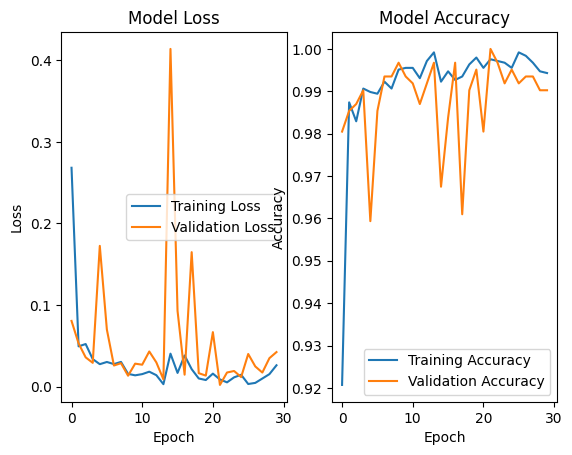

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step


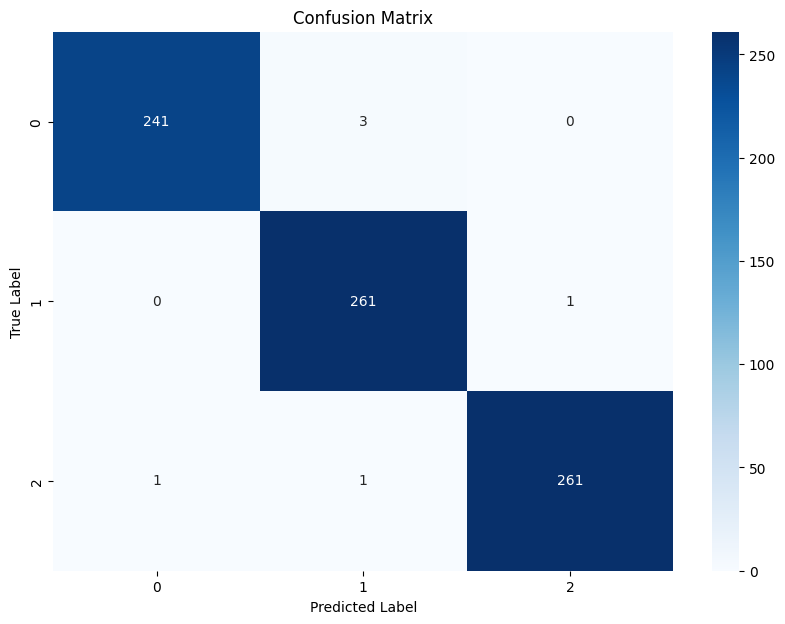

**********REPORT FOR  INCEPTIONV3  MODEL********** /n
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
              precision    recall  f1-score   support

       eagle       1.00      0.99      0.99       244
       panda       0.98      1.00      0.99       262
  polar-bear       1.00      0.99      0.99       263

    accuracy                           0.99       769
   macro avg       0.99      0.99      0.99       769
weighted avg       0.99      0.99      0.99       769

******************************************


In [6]:
import argparse
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import layers, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.models import load_model, Model
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


base_model = keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
    )
base_model.summary()

  # Fine-tuning
for layer in base_model.layers[:260]:
       layer.trainable = False
for layer in base_model.layers[260:]:
       layer.trainable = True


x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1900, activation='relu')(x)
x = keras.layers.Dropout(0.27)(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)


inception_model = keras.models.Model(inputs=base_model.input, outputs=predictions)

inception_model.summary()
inception_model.compile(
optimizer=keras.optimizers.Adam(learning_rate= 0.0008053532244671809),
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)
history = inception_model.fit(train_set, epochs=30, validation_data=val_set, callbacks=[stop_early])
inception_model.save('inception_model.h5')

# Evaluacija modela
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_set = test_datagen.flow(test_imgs, test_labels, batch_size=32, shuffle=False)
test_loss, test_accuracy = inception_model.evaluate(test_set)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

#Prikaz rezultata
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Confusion matrica
test_predictions = inception_model.predict(test_imgs)
test_predictions = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels

conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

report_model(inception_model, "inceptionv3", test_imgs, test_labels, class_map)